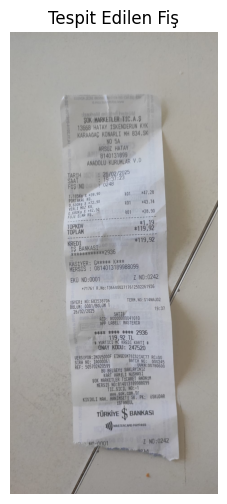

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntüyü yükleme
image_path = "receipt_Sample.jpg"
image = cv2.imread(image_path)

# Görüntüyü gri tonlamaya çevirme
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Gürültüyü azaltmak için bulanıklaştırma
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Kenarları belirlemek için Canny kenar algılama
edges = cv2.Canny(blurred, 50, 150)

# Konturları bulma
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# En büyük dörtgeni bulma
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

receipt_contour = None
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:  # Dört köşe bulduysak
        receipt_contour = approx
        break

# Köşeleri çizme
image_copy = image.copy()
if receipt_contour is not None:
    cv2.drawContours(image_copy, [receipt_contour], -1, (0, 255, 0), 3)

# Sonucu gösterme
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("Tespit Edilen Fiş")
plt.axis("off")
plt.show()

# Tespit edilen köşeleri gösterme
receipt_contour.reshape(4, 2) if receipt_contour is not None else None


In [4]:
def order_points(pts):
    """Dört köşeyi sıralı hale getir (sol üst, sağ üst, sağ alt, sol alt)"""
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Sol üst
    rect[2] = pts[np.argmax(s)]  # Sağ alt

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Sağ üst
    rect[3] = pts[np.argmax(diff)]  # Sol alt

    return rect

if receipt_contour is not None:
    print("burada")
    # Köşeleri sırala
    ordered_pts = order_points(receipt_contour.reshape(4, 2))

    # Hedef dönüşüm noktaları
    (tl, tr, br, bl) = ordered_pts
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [maxWidth - 1, 0], 
                    [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")

    # Perspektif dönüşüm matrisini hesapla
    M = cv2.getPerspectiveTransform(ordered_pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Sonucu gösterme
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Düzeltilmiş Fiş")
    plt.axis("off")
    plt.show()

    # Düzeltilmiş fişi kaydetme
    output_path = "warped_receipt.jpg"
    cv2.imwrite(output_path, warped)
    output_path


In [ ]:
# Görüntüyü yeniden yükleyip işlemleri tekrar yapalım
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Kontrastı artırmak için eşikleme uygulayalım
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Kenarları belirlemek için tekrar Canny uygula
edges = cv2.Canny(thresh, 50, 150)

# Konturları bul
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Alanı en büyük olan konturu al
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0] if contours else None

# Eğer 4 köşe bulamazsak, en büyük dikdörtgeni alalım
receipt_contour = None

if largest_contour is not None:
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    if len(approx) == 4:  # Eğer 4 köşe varsa kullan
        receipt_contour = approx
    else:  # Yoksa minAreaRect ile dikdörtgen al
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        receipt_contour = np.int8(box)

# Tespit edilen köşeleri çizdirme
image_copy = image.copy()
if receipt_contour is not None:
    cv2.drawContours(image_copy, [receipt_contour], -1, (0, 255, 0), 3)

# Sonucu gösterme
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("Fişin Tespit Edilen Alanı")
plt.axis("off")
plt.show()

# Tespit edilen köşeleri döndürme
receipt_contour.reshape(4, 2) if receipt_contour is not None else None


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2546: error: (-215:Assertion failed) npoints > 0 in function 'cv::drawContours'
